<a href="https://colab.research.google.com/github/affanmalik02/dlmusicplaylist/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
This section imports songs from the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). This has 30 second clips of 100 songs from 10 genres. The songs come pre-processed in the Mel-Spectrogram format which is what we will use to train our CNN. The path to the spectrograms is saved in the spectrogramsPath variable. The (genre, image-array) pairs are saved into the array called data.

In [ ]:
import kagglehub
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [ ]:
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)
spectrogramsPath = path + '/Data/images_original'

100%|██████████| 1.21G/1.21G [00:11<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
genre_spectrogram_pairs = []
base_path_length = len(spectrogramsPath) + 1

for root, dirs, files in os.walk(spectrogramsPath):
    genre = root[base_path_length:]
    for file in files:
        file_path = os.path.join(spectrogramsPath, genre, file)
        img = Image.open(file_path)
        spectrogram_array = np.array(img)

        genre_spectrogram_pairs.append((genre, spectrogram_array))

print(f"Total spectrograms processed: {len(genre_spectrogram_pairs)}")
print(f"Data entry: {genre_spectrogram_pairs[0]}")

Total spectrograms processed: 999
Data entry: ('classical', array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 

Genre: classical Observation Count: 100
Genre: country Observation Count: 100
Genre: rock Observation Count: 100
Genre: jazz Observation Count: 99
Genre: hiphop Observation Count: 100
Genre: metal Observation Count: 100
Genre: blues Observation Count: 100
Genre: pop Observation Count: 100
Genre: disco Observation Count: 100
Genre: reggae Observation Count: 100


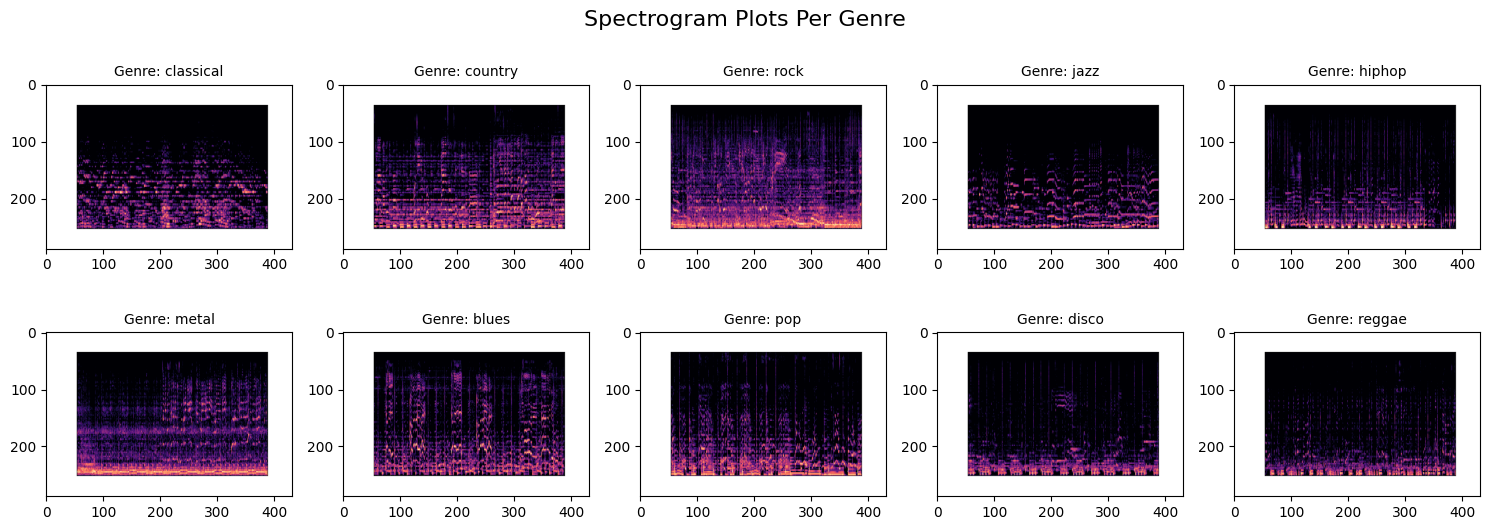

In [ ]:
unique_genre_spectrograms = {}
genre_class_count = defaultdict(int)
for genre, img_array in genre_spectrogram_pairs:
    genre_class_count[genre] += 1
    if genre not in unique_genre_spectrograms:
        unique_genre_spectrograms[genre] = img_array

# printing genre wise information
for genre,count in genre_class_count.items():
  print(f"Genre: {genre} Observation Count: {count}")

unique_genres = list(unique_genre_spectrograms.keys())
unique_images = list(unique_genre_spectrograms.values())

num_genres = 10
columns = 5
rows = 2

# Create a figure for the grid of spectrograms
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))
fig.suptitle("Spectrogram Plots Per Genre", fontsize=16, y=0.92)

for i, (genre, img_array) in enumerate(zip(unique_genres, unique_images)):
    row, col = divmod(i, columns)
    ax = axes[row, col]

    ax.imshow(img_array, cmap='viridis')
    ax.set_title(f"Genre: {genre}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
"""
The goal of this function is to ensure that the inputs are consistent in size
before being passed into the CNN network. Converting the image to grayscale
simplifies the input by reducing the number of channels, which are not required
for our task.
"""
def preprocess_spectrogram(image_array, target_size=(128, 130)):
    """
    Preprocess spectrograms by resizing and normalizing them.
    Args:
        image_array (ndarray): Input spectrogram as a numpy array.
        target_size (tuple): Target size (height, width) for resizing.
    Returns:
        ndarray: Processed spectrogram.
    """
    img = Image.fromarray(image_array)
    img = img.resize((target_size[1], target_size[0]), Image.Resampling.LANCZOS)  # (width, height)
    img = ImageOps.grayscale(img)  # Convert to grayscale
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

"""
This function calculates a single time segment for the spectrogram being
processed.

image_array --> 2D spectrogram.
segment_length --> Defines the number of columns in the segment (time bins).
overlap --> Fraction of overlap between consecutive segments. Set to
            0.5 as in the baseline reference paper.
"""
def segment_spectrogram(image_array, segment_length, total_bins, overlap=0.5):
    step_size = int(segment_length * (1 - overlap))  # Sliding step for segmentation
    segments = []
    num_segments = (total_bins - segment_length) // step_size + 1  # Calculate max number of valid segments

    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length
        if end <= image_array.shape[1]:  # Ensure the segment fits within the spectrogram
            segment = image_array[:, start:end]
            segments.append(segment)
    return segments


# Parameters
segment_length = 130
track_duration = 30
time_per_bin = 0.023
total_bins = int(track_duration / time_per_bin)
overlap = 0.5

preprocessed_data = []
for genre, img_array in genre_spectrogram_pairs:
    preprocessed_img = preprocess_spectrogram(img_array, target_size=(128, total_bins))
    segments = segment_spectrogram(preprocessed_img, segment_length, total_bins, overlap)
    for segment in segments:
        preprocessed_data.append((genre, segment))

# **Spectogram Dataset**

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, preprocessed_data, label_mapping):
        self.data = preprocessed_data
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        genre, segment = self.data[idx]
        label = self.label_mapping[genre]
        segment_tensor = torch.tensor(segment, dtype=torch.float32).unsqueeze(0) # adding the channel for grayscale
        return segment_tensor, label

In [ ]:
# Label Mapping
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
label_mapping = {genre: idx for idx, genre in enumerate(genres)}

'''
The data splitting has been done as per how it was performed in the reference paper
'''

# Split data into train (50%) and temp (50%)
train_data, temp_data = train_test_split(preprocessed_data, test_size=0.5, random_state=42)
# Split temp into validation (20%) and test (30%)
val_data, test_data = train_test_split(temp_data, test_size=0.6, random_state=42)
print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_data)}")

#datasets
train_dataset = SpectrogramDataset(train_data, label_mapping)
val_dataset = SpectrogramDataset(val_data, label_mapping)
test_dataset = SpectrogramDataset(test_data, label_mapping)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Size: 9490, Validation Size: 3796, Test Size: 5695


#**Spectogram Model**

In [ ]:
"""
The main drawback of the baseline reference paper was that it primarily focused on the temporal features
of the spectrogram without much emphasis on the spectral features, which are equally important.

To address this limitation, this model introduces a parallel architecture with two separate branches:
- The Temporal branch processes features related to changes over time.
- The Spectral branch processes features related to frequency components.

The outputs from these two branches are combined into a dense feature map, which is then passed through
a softmax layer to predict the probabilities for each genre.
"""

class SpectrogramCNN(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_prob=0.3):
        super(SpectrogramCNN, self).__init__()

        # Temporal branch: Focuses on changes over time (horizontal features)
        self.temporal_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), padding=(0, 3)),  # Horizontal filters
            nn.BatchNorm2d(64),  # Normalize feature maps to stabilize training
            nn.ReLU(inplace=True),  # Activation function for non-linearity
            nn.Conv2d(64, 128, kernel_size=(1, 7), padding=(0, 3)),  # More horizontal filters
            nn.BatchNorm2d(128),  # Further normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))  # Reduce feature map size (height and width)
        )

        # Spectral branch: Focuses on frequency components (vertical features)
        self.spectral_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 1), padding=(3, 0)),  # Vertical filters
            nn.BatchNorm2d(64),  # Normalize feature maps
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(7, 1), padding=(3, 0)),  # More vertical filters
            nn.BatchNorm2d(128),  # Further normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))  # Reduce feature map size (height and width)
        )

        # Combine branches: Merge temporal and spectral features
        self.combine_branches = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),  # 1x1 convolution to reduce the number of channels
            nn.BatchNorm2d(128),  # Normalize the combined feature maps
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)  # Apply dropout for regularization
        )

        # Final classifier: Predict genre probabilities
        self.classifier = nn.Sequential(
            nn.Conv2d(128, num_classes, kernel_size=1),  # Reduce channels to the number of classes
            nn.AdaptiveAvgPool2d(1)  # Global average pooling to output 1x1 feature maps
        )

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (Tensor): Input spectrogram segment.
        Returns:
            Tensor: Log probabilities for each genre.
        """
        temp_out = self.temporal_branch(x)
        spec_out = self.spectral_branch(x)

        # Combine the outputs from both branches along the channel dimension
        combined_features = torch.cat([temp_out, spec_out], dim=1)
        # Further process combined features
        combined_features = self.combine_branches(combined_features)
        # Classify using the final layer
        logits = self.classifier(combined_features).squeeze(-1).squeeze(-1)  # Remove extra dimensions
        # Return log probabilities for each class
        return F.log_softmax(logits, dim=1)



# Training

In [ ]:
def train_with_validation(model, train_loader, val_loader, learning_rate=0.001, epochs=50, patience=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the appropriate device

    # Define optimizer, learning rate scheduler, and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    criterion = nn.CrossEntropyLoss()

    # NEW LINE - DELETE IF CAUSES ISSUES
    train_loss_data = []  # Stores training loss for each epoch
    train_accuracy_data = []  # Stores training accuracy for each epoch
    val_loss_data = []  # Stores validation loss for each epoch
    val_accuracy_data = []  # Stores validation accuracy for each epoch

    # Initialize variables for tracking best validation loss and early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    print("Starting Training")

    for epoch in range(epochs):

        # ===== Training Phase =====
        model.train()
        train_loss, train_correct = 0.0, 0  # Initialize training metrics

        for inputs, labels in train_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: compute predictions
            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients and update weights
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # ===== Validation Phase =====
        model.eval()
        val_loss, val_correct = 0.0, 0  # Initialize validation metrics

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                # Move data to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass: compute predictions
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, labels)

                # Update validation metrics
                val_loss += loss.item() * inputs.size(0)  # Accumulate weighted loss
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()  # Count correct predictions

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        # Append metrics to arrays
        # NEW LINE - DELETE IF CAUSES ISSUES
        train_loss_data.append(train_loss)
        train_accuracy_data.append(train_accuracy)
        val_loss_data.append(val_loss)
        val_accuracy_data.append(val_accuracy)

        # Step the learning rate scheduler
        scheduler.step()

        # ===== Early Stopping =====
        if val_loss < best_val_loss:
            # If validation loss improves, save the model and reset patience counter
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save the model with the best validation loss
        else:
            # If no improvement, increment patience counter
            patience_counter += 1

        if patience_counter >= patience:
            # Stop training if validation loss does not improve for 'patience' epochs
            print("Early stopping triggered.")
            break

    # NEW LINE - DELETE IF CAUSES ISSUES
    return train_loss_data, train_accuracy_data, val_loss_data, val_accuracy_data


In [ ]:
# Initialize model
input_shape = (128, 130)
num_classes = 10
model = SpectrogramCNN(input_shape=input_shape, num_classes=num_classes)

# Train the model
train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.0080,
    epochs=50,
    patience=5
)


Starting Training
Epoch 1/50 | Train Loss: 1.9494 | Train Acc: 0.2705 | Val Loss: 1.7778 | Val Acc: 0.3238
Epoch 2/50 | Train Loss: 1.7035 | Train Acc: 0.3733 | Val Loss: 2.0860 | Val Acc: 0.3114
Epoch 3/50 | Train Loss: 1.6197 | Train Acc: 0.4129 | Val Loss: 2.7519 | Val Acc: 0.2442
Epoch 4/50 | Train Loss: 1.5489 | Train Acc: 0.4365 | Val Loss: 1.5698 | Val Acc: 0.4452
Epoch 5/50 | Train Loss: 1.5099 | Train Acc: 0.4619 | Val Loss: 1.5515 | Val Acc: 0.4536
Epoch 6/50 | Train Loss: 1.4877 | Train Acc: 0.4627 | Val Loss: 1.6831 | Val Acc: 0.4199
Epoch 7/50 | Train Loss: 1.4528 | Train Acc: 0.4804 | Val Loss: 1.9067 | Val Acc: 0.3404
Epoch 8/50 | Train Loss: 1.4170 | Train Acc: 0.4944 | Val Loss: 1.4138 | Val Acc: 0.5063
Epoch 9/50 | Train Loss: 1.4022 | Train Acc: 0.5032 | Val Loss: 1.4026 | Val Acc: 0.5053
Epoch 10/50 | Train Loss: 1.3646 | Train Acc: 0.5224 | Val Loss: 1.2989 | Val Acc: 0.5688
Epoch 11/50 | Train Loss: 1.3191 | Train Acc: 0.5429 | Val Loss: 1.2658 | Val Acc: 0.5738
E

([1.94942159092464,
  1.7034764963909748,
  1.6196918793297417,
  1.5488760518575493,
  1.509939607503668,
  1.4877236879286448,
  1.4528171882237473,
  1.4169966432643766,
  1.4022420989449584,
  1.3646377137136911,
  1.3190794984960204,
  1.291893468830181,
  1.2664699723522077,
  1.2533285200784279,
  1.2331355352673063,
  1.2219189957396626,
  1.1861398627057091,
  1.1864858323329366,
  1.1582311808246455,
  1.1457027094381753,
  1.1159580310102006,
  1.090540708668993,
  1.0815182393418725,
  1.060493912485804,
  1.0462596458931492,
  1.0405232234800075,
  1.0374941647743652,
  1.0254163787035846,
  1.0143866931801726,
  1.0002265903042793,
  0.9740980096310534,
  0.9542522129947192,
  0.9515608905238523,
  0.9411426766780455,
  0.9373344850489915,
  0.9168126463261997,
  0.9269712813661775,
  0.9162055652937975,
  0.9165992483575176,
  0.9004556540191739,
  0.8880482900758186,
  0.8718548884758582,
  0.8674180228793081,
  0.8590328305111795,
  0.8518826147402049,
  0.840094018912

# **Testing**

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move model to the appropriate device
    criterion = nn.CrossEntropyLoss()  # Loss function for classification

    test_loss, test_correct = 0.0, 0  # Initialize metrics

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to get predictions
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # Accumulate weighted loss

            # Count correct predictions
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)

    return test_loss, test_accuracy


In [ ]:

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramCNN(input_shape=(128, 87), num_classes=len(label_mapping))  # Initialize the model
model.load_state_dict(torch.load("best_model.pt"))  # Load the saved best model weights

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for test set
test_loss, test_accuracy = evaluate_model(model, test_loader, device)

# Print the results
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

<ipython-input-12-49b355d571fc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))  # Load the saved best model weights


Test Loss: 0.7778 | Test Accuracy: 0.7477


# Graphs

Graphs: \\
Compare spectrograms from songs in playlist. \\




# Experiments
We will focus on tuning two hyperparameters to see their effects on the training and validation loss curves. The hyperparameters are as follows:
1. Learning Rate
2. Number of Epochs
3. Patience

## Learning Rate#


Training with learning rate: 0.0001
Starting Training
Epoch 1/10 | Train Loss: 2.1459 | Train Acc: 0.2195 | Val Loss: 2.0352 | Val Acc: 0.2924
Epoch 2/10 | Train Loss: 2.0000 | Train Acc: 0.2827 | Val Loss: 1.9326 | Val Acc: 0.3180
Epoch 3/10 | Train Loss: 1.9232 | Train Acc: 0.3094 | Val Loss: 1.8787 | Val Acc: 0.3267
Epoch 4/10 | Train Loss: 1.8725 | Train Acc: 0.3297 | Val Loss: 1.8642 | Val Acc: 0.3438
Epoch 5/10 | Train Loss: 1.8285 | Train Acc: 0.3398 | Val Loss: 1.7977 | Val Acc: 0.3712
Epoch 6/10 | Train Loss: 1.7920 | Train Acc: 0.3632 | Val Loss: 1.7948 | Val Acc: 0.3633
Epoch 7/10 | Train Loss: 1.7673 | Train Acc: 0.3688 | Val Loss: 1.7754 | Val Acc: 0.3438
Epoch 8/10 | Train Loss: 1.7498 | Train Acc: 0.3784 | Val Loss: 1.7183 | Val Acc: 0.3896
Epoch 9/10 | Train Loss: 1.7258 | Train Acc: 0.3812 | Val Loss: 1.6813 | Val Acc: 0.4204
Epoch 10/10 | Train Loss: 1.7042 | Train Acc: 0.3895 | Val Loss: 1.6975 | Val Acc: 0.3975
Training with learning rate: 0.001
Starting Training
Ep

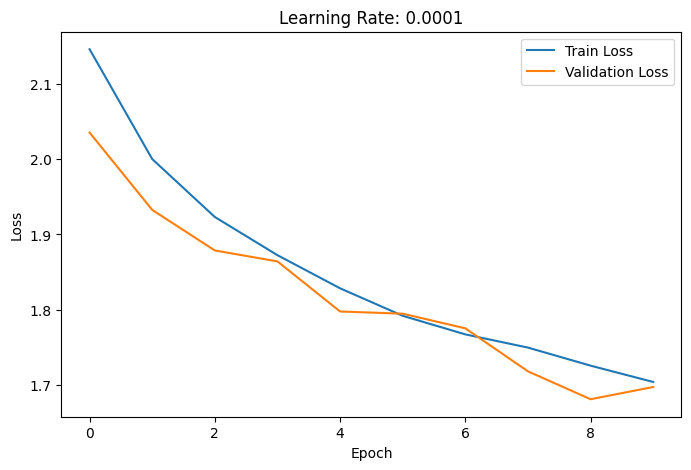

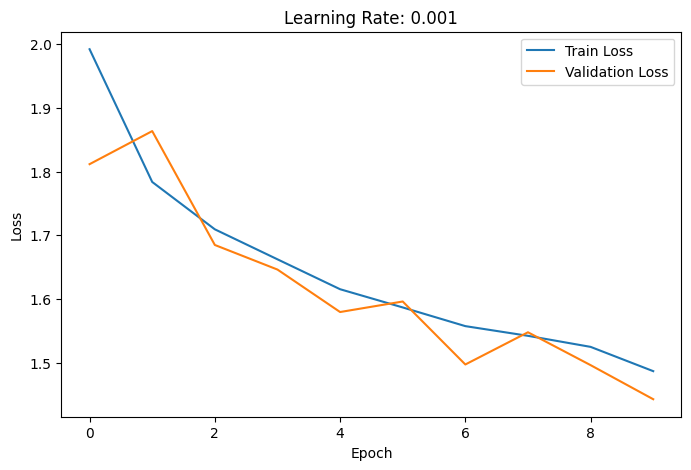

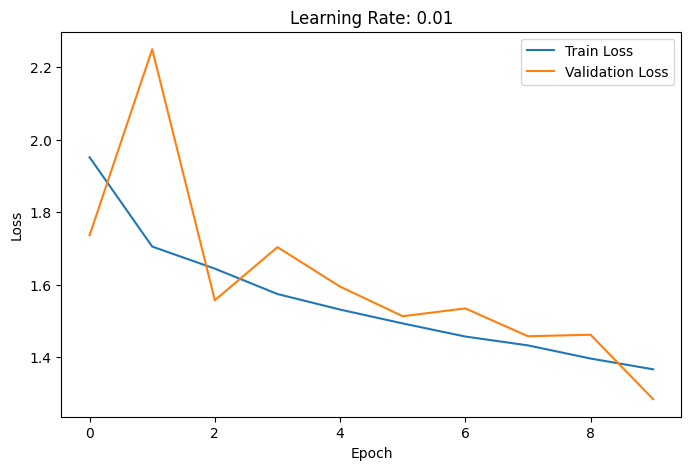

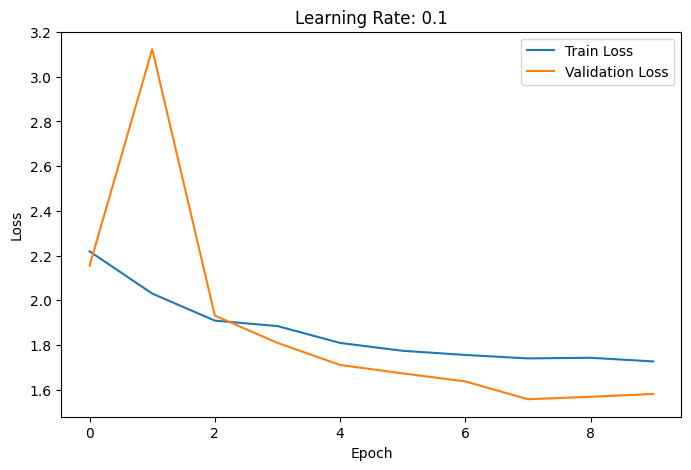

In [ ]:
# experimenting with learning rates
loss_fn = nn.CrossEntropyLoss()
learning_rates = [0.0001, 0.001, 0.01, 0.1] # CHANGE THIS
results = {}

# loop over all learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)  # Reinitialize the model for each learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # train the model for the specified lr
    train_losses, train_accuracy, val_losses, val_accuracy = train_with_validation(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=lr,
        epochs=10,
        patience=5
    )
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# plotting the results
for lr, losses in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(losses['train_losses'], label='Train Loss')
    plt.plot(losses['val_losses'], label='Validation Loss')
    plt.title(f"Learning Rate: {lr}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# plotting the results
for lr, losses in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(losses['train_losses'], label='Train Loss')
    plt.plot(losses['val_losses'], label='Validation Loss')
    plt.title(f"Learning Rate: {lr}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Number of Epochs
We will be disregarding this approach since it will take forever to run different number of Epochs and it is not feasible for this project due to time constaints.

In [ ]:
# experimenting with number of epochs
epoch_values = [5, 10, 20, 30]  # CHANGE THIS
results = {}

for num_epochs in epoch_values:
    print(f"Training with {num_epochs} epochs")

    model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # train the model for the specified number of epochs
    train_losses, val_losses = train_with_validation(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=0.001,
        epochs=num_epochs,
        patience=5
    )
    results[num_epochs] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# plotting the results
for num_epochs, losses in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(losses['train_losses'], label='Train Loss')
    plt.plot(losses['val_losses'], label='Validation Loss')
    plt.title(f"Number of Epochs: {num_epochs}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Training with 5 epochs


NameError: name 'SpectrogramCNN' is not defined

## Patience

In [ ]:
patience_values = [2, 5, 10, 20]
results = {}

for patience in patience_values:
    print(f"Training with patience: {patience}")

    model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # train the model for the specified patience
    train_losses, val_losses = train_with_validation(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=0.001,
        epochs=10,
        patience=patience
    )
    results[patience] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

In [ ]:
model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model for the specified patience
train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.001,
    epochs=20,
    patience=10
)

In [ ]:
model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model for the specified patience
train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.001,
    epochs=50,
    patience=20
)

## Fine Tuning Model Experiment

In [ ]:
class SpectrogramCNNWithFineTuning(SpectrogramCNN):
    def __init__(self, input_shape, num_classes, dropout_prob=0.3):
        super(SpectrogramCNNWithFineTuning, self).__init__(input_shape, num_classes, dropout_prob)

        # After the original classifier layer of the model, added a fully connected block as an experiment:
        # - First Layer: A linear layer maps the logits (predictions from the base model) into a smaller feature space
        # - ReLU Activation: Adds non-linearity to the model for better learning
        # - Dropout: Regularizes the model by randomly dropping some connections during training, to try reducing overfitting
        # - Final Linear Layer: Maps the reduced feature space back to the number of output classes (e.g., 10 genres)
        self.fine_tuning_block = nn.Sequential(
            nn.Linear(num_classes, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        logits = super(SpectrogramCNNWithFineTuning, self).forward(x)
        logits = logits.unsqueeze(-1).unsqueeze(-1)
        logits = logits.view(logits.size(0), -1)  # Flatten before the fine-tuning block
        fine_tuned_logits = self.fine_tuning_block(logits)
        return F.log_softmax(fine_tuned_logits, dim=1)

In [ ]:
input_shape = (1, 128, 130)  # Single-channel grayscale spectrogram
num_classes = 10
dropout_prob = 0.3

# Initialize base model and load weights
base_model = SpectrogramCNN(input_shape=input_shape, num_classes=num_classes, dropout_prob=dropout_prob)
base_model.load_state_dict(torch.load("best_model.pt"))

# Initialize fine-tuning model
fine_tuned_model = SpectrogramCNNWithFineTuning(input_shape=input_shape, num_classes=num_classes, dropout_prob=dropout_prob)
fine_tuned_model.load_state_dict(base_model.state_dict(), strict=False)  # Load base weights

# Train the fine-tuned model
train_with_validation(
  model=fine_tuned_model,
  train_loader=train_loader,
  val_loader=val_loader,
  epochs=20,
  learning_rate=0.001,
  patience=5
)

## Comparing Results with Other Model

Sridhar
**College Students: 70% accuracy of genre classification**

George Tzanetakis and Perry Cook. Musical genre classification of audio
signals. IEEE Transactions on speech and audio processing, 10(5):293–302, 2002.
**Accuracy: 0.62**

**Swin Transformer-based method obtained a precision of 81.1%**
Zhao, H.; Zhang, C.; Zhu, B.; Ma, Z.; Zhang, K. S3t: Self-supervised pre-training with swin transformer for music classification. In Proceedings of the ICASSP 2022-2022 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Singapore, 22–27 May 2022; IEEE: Piscataway, NJ, USA, 2022; pp. 606–610. [Google Scholar]

Chen, J.; Ma, X.; Li, S.; Ma, S.; Zhang, Z.; Ma, X. A Hybrid Parallel Computing Architecture Based on CNN and Transformer for Music Genre Classification. Electronics 2024, 13, 3313. https://doi.org/10.3390/electronics13163313
**OA, precision, recall, and F1 of 87.41%, 87.93%, 87.58%, and 87.28%, respectively.**




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their corresponding accuracies
models = [
    'Our Model',
    'College Students Survey',
    'Tzanetakis & Cook (2002)',
    'Zhao et al. (2022)',
    'Chen et al. (2024)',
    'MobileNet V2',
    'MobileNet V3 small',
    'MobileNet V3 large',
    'GhostNet 100',
    'EfficientNet B0',
    'EfficientNet V2 B0',
    'DenseNet121',
    'ResNet18',
    'ResNet34',
    'Inception V3',
    'Inception V4',
    'Xception',
    'ViT',
    'MoblileViT small',
    'Swin Transformer',
    'CNN-TE'
]

accuracies = [
    74.77,  # Our Model
    70.0,   # College Students Survey
    62.0,   # Tzanetakis & Cook (2002)
    81.1,   # Zhao et al. (2022)
    87.41,  # Chen et al. (2024)
    80.37,  # MobileNet V2
    79.88,  # MobileNet V3 small
    78.91,  # MobileNet V3 large
    78.12,  # GhostNet 100
    78.42,  # EfficientNet B0
    80.18,  # EfficientNet V2 B0
    86.31,  # DenseNet121
    85.51,  # ResNet18
    84.55,  # ResNet34
    83.30,  # Inception V3
    82.03,  # Inception V4
    84.42,  # Xception
    71.03,  # ViT
    73.02,  # MoblileViT small
    80.06,  # Swin Transformer
    87.41   # CNN-TE
]

# Sort models and accuracies
sorted_indices = np.argsort(accuracies)[::-1]  # Sort in descending order
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Assign colors: Highlight 'Our Model' in a different color
colors = ['green' if model != 'Our Model' else 'orange' for model in sorted_models]

# Plotting the accuracies
plt.figure(figsize=(14, 8))
bars = plt.bar(sorted_models, sorted_accuracies, color=colors)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Music Genre Classification Accuracies (Ordered)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotating each bar with the accuracy percentage
for index, value in enumerate(sorted_accuracies):
    plt.text(index, value + 1, f"{value}%", ha='center', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# PCA Visualization - Relationship between Genres

This visualization will map out features from the trained music, making it easier to understand how different genres relate to each other. \\


In [ ]:
def extract_embeddings(model, dataloader, device):
    """
    Get embeddings from the trained model for each spectrogram segment in the dataloader.
    Args:
        model: Trained CNN model.
        dataloader: DataLoader for spectrogram segments.
        device: 'cpu' or 'cuda' for computation.
    Returns:
        embeddings: Dictionary with genre as keys and a list of embeddings as values.
    """
    model.eval()
    embeddings = defaultdict(list)

    with torch.no_grad():
        for batch in dataloader:
            genres, spectrograms = batch
            spectrograms = spectrograms.to(device).float()

            # reshape to add a channel dimension (1, height, width)
            spectrograms = spectrograms.unsqueeze(1)

            # forward pass through the model
            outputs = model(spectrograms)
            outputs = outputs.cpu().numpy()

            for genre, embedding in zip(genres, outputs):
                embeddings[genre].append(embedding)  # use genre as the key

    return embeddings

def compute_genre_signatures(embeddings):
    """
    Compute the average embedding for each genre.
    Args:
        embeddings: Dictionary with genre as keys and list of embeddings as values.
    Returns:
        genre_signatures: Dictionary with genre as keys and average embedding as values.
    """
    genre_signatures = {genre: np.mean(embs, axis=0) for genre, embs in embeddings.items()}
    return genre_signatures

def plot_pca(genre_signatures, dimensions=2):
    """
    Perform PCA and plot the reduced dimensionality data.
    Args:
        genre_signatures: Dictionary with genre as keys and average embedding as values.
        dimensions: Target dimensions for PCA (2D or 3D).
    """
    genres = list(genre_signatures.keys())
    embeddings = np.array(list(genre_signatures.values()))

    pca = PCA(n_components=dimensions)
    reduced_embeddings = pca.fit_transform(embeddings)

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        for i, genre in enumerate(genres):
            plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=genre)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('PCA Visualization of Genre Embeddings')
        plt.legend()
        plt.show()
    elif dimensions == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        for i, genre in enumerate(genres):
            ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], label=genre)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        plt.title('PCA Visualization of Genre Embeddings')
        plt.legend()
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the Best Model
best_model = SpectrogramCNN(input_shape=(128, 130), num_classes=10)  # model architecture
best_model.load_state_dict(torch.load("best_model.pt", map_location=device))  # load best model
best_model.to(device)  # move to device

# extract Embeddings
# create a DataLoader for the validation/test set
test_loader = DataLoader(preprocessed_data, batch_size=32, shuffle=False)
embeddings = extract_embeddings(best_model, test_loader, device)

# compute Genre Signatures
genre_signatures = compute_genre_signatures(embeddings)

# plot PCA
plot_pca(genre_signatures, dimensions=2)  # For 2D PCA
plot_pca(genre_signatures, dimensions=3)  # For 3D PCA